Imports and read and sample data to correct indervals

In [88]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from scipy.signal import savgol_filter

from wOpenTimes import ( 
    WINDOW_OPEN_TIMES
)

inside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_temperature.csv', parse_dates=['Time'])
inside_temp_data = inside_temp_data.iloc[1:].reset_index(drop=True)
inside_temp_data.columns = ['Time', 'Temperature']
inside_temp_data['Temperature'] = inside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
inside_temp_data['Temperature'] = pd.to_numeric(inside_temp_data['Temperature'], errors='coerce')

outside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_temperature.csv', parse_dates=['Time'])
outside_temp_data = outside_temp_data.iloc[1:].reset_index(drop=True)
outside_temp_data.columns = ['Time', 'Temperature']
outside_temp_data['Temperature'] = outside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
outside_temp_data['Temperature'] = pd.to_numeric(outside_temp_data['Temperature'], errors='coerce')

inside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_humidity.csv', parse_dates=['Time'])
inside_humidity_data = inside_humidity_data.iloc[1:].reset_index(drop=True)
inside_humidity_data['Humidity'] = inside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
inside_humidity_data['Humidity'] = pd.to_numeric(inside_humidity_data['Humidity'], errors='coerce')

outside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_humidity.csv', parse_dates=['Time'])
outside_humidity_data = outside_humidity_data.iloc[1:].reset_index(drop=True)
outside_humidity_data['Humidity'] = outside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
outside_humidity_data['Humidity'] = pd.to_numeric(outside_humidity_data['Humidity'], errors='coerce')

outside_temp_data = outside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
inside_temp_data = inside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
inside_humidity_data = inside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
outside_humidity_data = outside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()

data_list = [inside_temp_data, outside_temp_data, outside_humidity_data, inside_humidity_data]

Normalize  and merge data into one DF

In [89]:
def normalize_data(data_frame: pd.DataFrame, file_type: str) -> pd.DataFrame:
    """
    This function normalizes the data by removing outliers and interpolating the data to 1 minute intervals.
    """

    if file_type == "temperature":
        value = "Temperature"
        lower_percentile = 0.01
        upper_percentile = 99.99
    elif file_type == "humidity":
        value = "Humidity"
        lower_percentile = 0.1
        upper_percentile = 99.9
    else:
        raise ValueError("Invalid file type")

    lower_threshold = data_frame[value].quantile(lower_percentile / 100)
    upper_threshold = data_frame[value].quantile(upper_percentile / 100)

    df_filtered = data_frame[(data_frame[value] >= lower_threshold) & (data_frame[value] <= upper_threshold)]
    df_filtered = df_filtered.set_index('Time').resample('1T').interpolate('linear').reset_index()

    return df_filtered

inside_temp_data = data_list[0]
outside_temp_data = data_list[1]
outside_humidity_data = data_list[2]
inside_humidity_data = data_list[3]

inside_temp_data = normalize_data(inside_temp_data, "temperature")
outside_temp_data = normalize_data(outside_temp_data, "temperature")

inside_humidity_data = normalize_data(inside_humidity_data, "humidity")
outside_humidity_data = normalize_data(outside_humidity_data, "humidity")

data = pd.merge_asof(inside_temp_data.sort_values('Time'), 
                    outside_temp_data.sort_values('Time'), 
                    on='Time', 
                    suffixes=('_inside', '_outside'))

# Drop rows with NaN values
data = data.dropna()

Smooth the temperature data

In [90]:
pre_smoothed_data = data.copy()

# Smooth the temperature data
#span = 15  # Determines the degree of smoothing
#data['Temperature_inside'] = data['Temperature_inside'].ewm(span=span, adjust=False).mean()

# Apply Savitzky-Golay filter
window_size = 9  # Choose an odd number (larger values = more smoothing)
poly_order = 2    # Polynomial order
data['Temperature_inside'] = savgol_filter(data['Temperature_inside'], window_size, poly_order)

Postprocess -> Create new collumns

In [91]:
# Define the window open times
window_open_times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in WINDOW_OPEN_TIMES]
data['Time'] = pd.to_datetime(data['Time'])
data['Window_Open'] = 0

for start_time in window_open_times:
    end_time = start_time + timedelta(minutes=31)
    data.loc[(data['Time'] >= start_time) & (data['Time'] < end_time), 'Window_Open'] = 1

# Calculate the time it takes to reach 24°C
data["Minutes_to_24"] = np.nan
counter = 0
goal_temperature = 24

for index, row in data.iloc[::-1].iterrows():

    if row['Window_Open'] == 0:
        counter = 0
        continue
    elif row['Temperature_inside'] >= goal_temperature and row['Window_Open'] == 1:
        counter += 1
        data.at[index, 'Minutes_to_24'] = counter

# Drop empty rows with window closed        
data = data.dropna(subset=['Minutes_to_24'])

# Round values to 1 digit
data = data.round(2)



Train an ANN

In [97]:
# Create training data
X = data[['Temperature_inside', 'Temperature_outside']].astype(float)
y = data['Minutes_to_24']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a scaler instance
#scaler = StandardScaler()
# Fit and transform the training data
#X_train = scaler.fit_transform(X_train)
# Optionally, transform the test data using the same scaler
#X_test = scaler.transform(X_test)

param_grid = {
    'hidden_layer_sizes': [(25, 25), (50, ), (50, 50), (50, 25), (100, 50), (100, 100), (200, 200) ],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.0001],
    'max_iter': [100, 200, 500, 1000, 2000],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'adam', 'sgd'],
}

# Create and train the model
#final_model = MLPRegressor(
#    hidden_layer_sizes=(50,),
#    alpha=0.01,
#    learning_rate_init=0.001,
#    activation='logistic',
#    solver='lbfgs',
#    early_stopping=True,
#    learning_rate='constant',
#    max_iter=1500,
#    random_state=42
#)

final_model = MLPRegressor(
    hidden_layer_sizes=(50, 50),
    alpha=0.01,
    learning_rate_init=0.001,
    activation='logistic',
    solver='lbfgs',
    early_stopping=True,
    learning_rate='constant',
    max_iter=15000,
    random_state=42
)
final_model.fit(X_train, y_train)

# Perform grid search
#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
#grid_search.fit(X_train, y_train)
#print("Best Parameters:", grid_search.best_params_)
#print("Best Score:", grid_search.best_score_)
#print("Best Estimator:", grid_search.best_estimator_)
#best_model = grid_search.best_estimator_

best_model = final_model

# Evaluate on test data (assuming you have a separate test set)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 18.2149699105566


/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Visuals

/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_

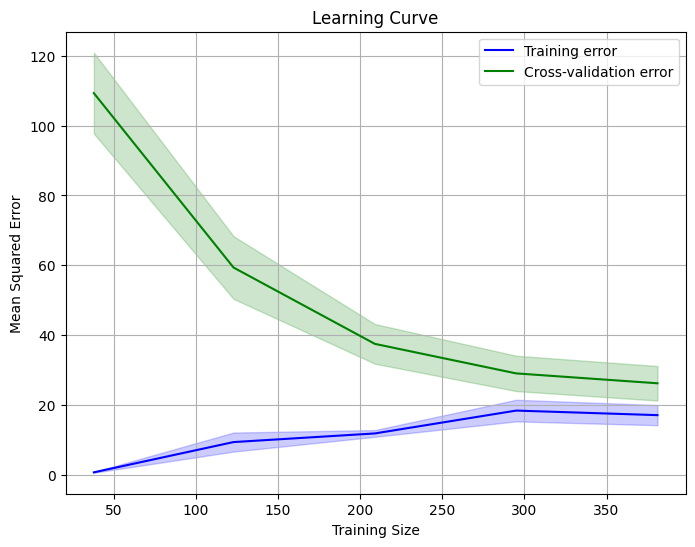

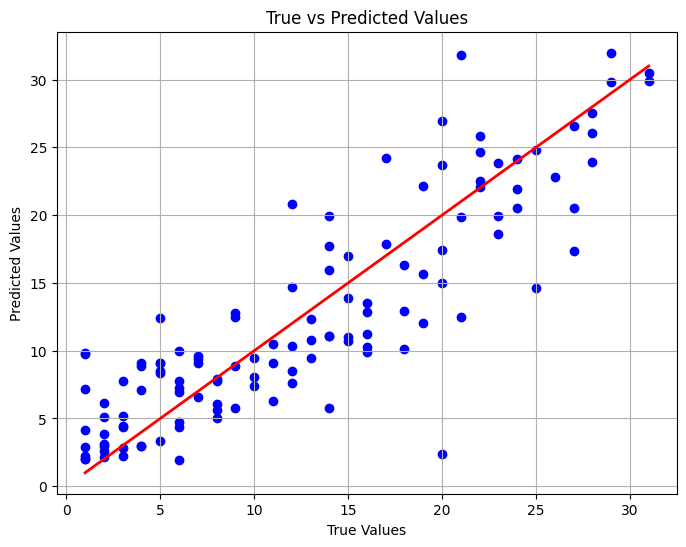

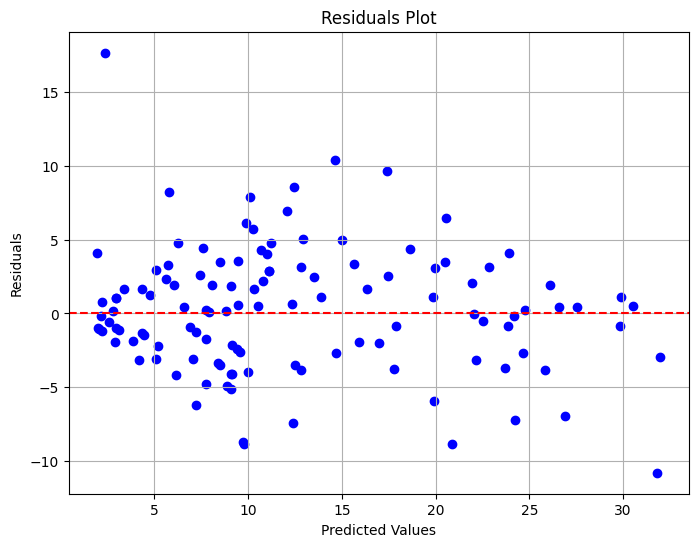

In [93]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate mean and std deviation for train and test scores
train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training error", color='blue')
plt.plot(train_sizes, test_mean, label="Cross-validation error", color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title("True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

In [110]:

temp_inside = 26
temp_outside = 1

minutes_to_cool = best_model.predict([[temp_inside, temp_outside]])[0]

print(f"Actual temperature: {temp_inside}°C")
print(f"Actual temperature outside: {temp_outside}°C")
print(f"To reach 24°C open window for {minutes_to_cool} minutes.")

Actual temperature: 26°C
Actual temperature outside: 1°C
To reach 24°C open window for 6.444471990968177 minutes.


/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
